**Problem statement**:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:


1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion

In [42]:
# importing libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import random

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [44]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [45]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [46]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [47]:
## Train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [48]:
## Validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [49]:

class_names = train_ds.class_names
print(class_names)
print(len(class_names))
print(range(len(class_names)))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9
range(0, 9)


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

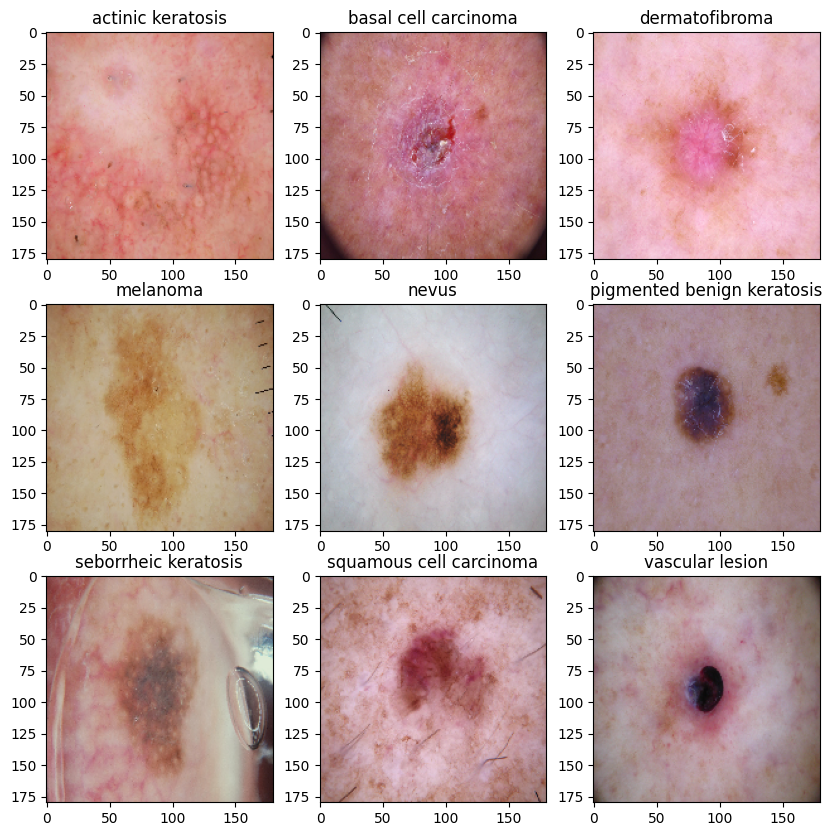

In [50]:

def data_visualization(train_data_dir, classes):
  fig = plt.figure(figsize=(10,10))
  for i in range(len(classes)):
    sdir = str(train_data_dir)+'/'+classes[i]
    flist = os.listdir(sdir)
    test_img = random.choice(flist)
    test_img = os.path.join(sdir, test_img)

    # Load and display the image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(load_img(test_img, target_size=(180, 180)))
    plt.title(classes[i])
    # plt.axis("off")
  plt.show()

data_visualization(data_dir_train, class_names)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# First Base Model

Starting with a base model with:
- 1 rescaling layer
- 3 hidden layers
- 1 FC layer
- 1 output of 9 classes

No dropouts have been added initially

In [52]:
### Your code goes here
model1 = Sequential()

# Rescaling
model1.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# 1st layer
model1.add(Conv2D(32, (3, 3), 1, activation='relu', input_shape=(img_height, img_width, 3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))


# third conv layer
model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model1.add(Flatten())
model1.add(Dense(128, activation='relu')) # fully connected

# softmax layer
model1.add(Dense(len(class_names), activation='softmax'))

### Compile the model


In [53]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [54]:
# View the summary of all layers
model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
# Create a log directory
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [16]:
epochs = 20
history1 = model1.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback])

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 196ms/step - accuracy: 0.2127 - loss: 2.0991 - val_accuracy: 0.2483 - val_loss: 1.9170
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3395 - loss: 1.7899 - val_accuracy: 0.3915 - val_loss: 1.6839
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4443 - loss: 1.5427 - val_accuracy: 0.5011 - val_loss: 1.4786
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5022 - loss: 1.4240 - val_accuracy: 0.5235 - val_loss: 1.4398
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5526 - loss: 1.2732 - val_accuracy: 0.5101 - val_loss: 1.3863
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5482 - loss: 1.2485 - val_accuracy: 0.5056 - val_loss: 1.5115
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5614 - loss: 1.2332 - val_accuracy: 0.4899 - val_loss: 1.5671
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6329 - loss: 1.0556 - val_accuracy: 0.5190 - val_lo

### Visualizing training results

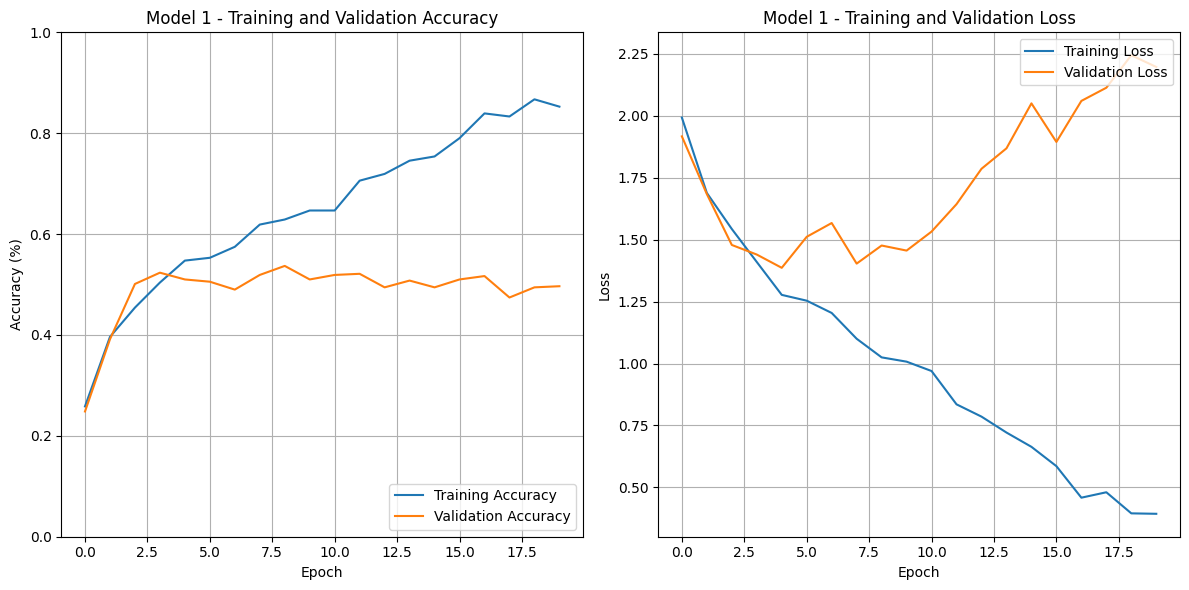

In [56]:


def plot_model_performance(hist, epoch, model_name):
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs_range = range(epochs)
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.ylim([0, 1])  # Set y-axis limits for accuracy
  plt.grid(True)  # Add grid for better readability
  plt.legend(loc='lower right')
  plt.title(f'{model_name} - Training and Validation Accuracy')  # Include model name
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')  # Add units to y-axis label

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.grid(True)  # Add grid
  plt.legend(loc='upper right')
  plt.title(f'{model_name} - Training and Validation Loss')  # Include model name
  plt.xlabel('Epoch')
  plt.ylabel('Loss')  # Add units to y-axis label

  plt.tight_layout()  # Prevent overlapping of plot elements
  plt.show()

plot_model_performance(history1, epochs, 'Model 1');

In [58]:
print("Model1: accurracy: ", history1.history['accuracy'][-1], "Validation accuracy: ", history1.history['val_accuracy'][-1])

Model1: accurracy:  0.8526785969734192 Validation accuracy:  0.4966442883014679




We observe that the 1st base model generates a good training accuracy but the accuracy on the validation set is very low. This is a good indication that the model is overfitting to the training data.

Let's try to randomize the dataset using keras. This data augmentation will help generalize the data by introducing certain variations like rotated images, zoomed in images, images with contrast etc. This should hopefully train our model a bit better. Let's observe if it reduces the overfitting



## Model 2

In [61]:
# Add a layer of randomizing the dataset

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
  ]
)

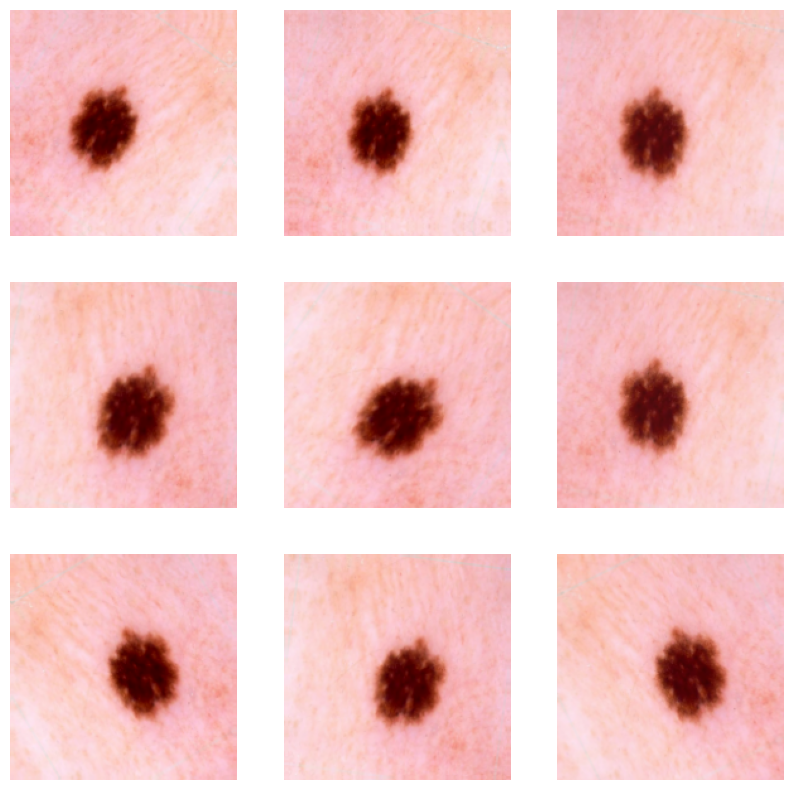

In [64]:
# Visualize the augmented data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

plt.show()

In [98]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
model2 = Sequential()

# add augmented data
model2.add(data_augmentation)

# Rescaling
model2.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# 1st layer
model2.add(Conv2D(32, (3, 3), 1, activation='relu', input_shape=(img_height, img_width, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# third conv layer
model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model2.add(Flatten())
model2.add(Dense(128, activation='relu')) # fully connected

# softmax layer
model2.add(Dense(len(class_names), activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [99]:

model2.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [100]:
# View the summary of all layers
model2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [101]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history2 = model2.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback])

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.2159 - loss: 2.0740 - val_accuracy: 0.3504 - val_loss: 1.8462
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.3693 - loss: 1.6690 - val_accuracy: 0.4529 - val_loss: 1.4714
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4169 - loss: 1.5370 - val_accuracy: 0.4803 - val_loss: 1.3730
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.4539 - loss: 1.4884 - val_accuracy: 0.4952 - val_loss: 1.2830
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4623 - loss: 1.4162 - val_accuracy: 0.5085 - val_loss: 1.2863
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.4578 - loss: 1.4168 - val_accuracy: 0.5278 - val_loss: 1.2150
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4630 - loss: 1.3776 - val_accuracy: 0.5226 - val_loss: 1.2049
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4880 - loss: 1.3234 - 

### Visualizing the results

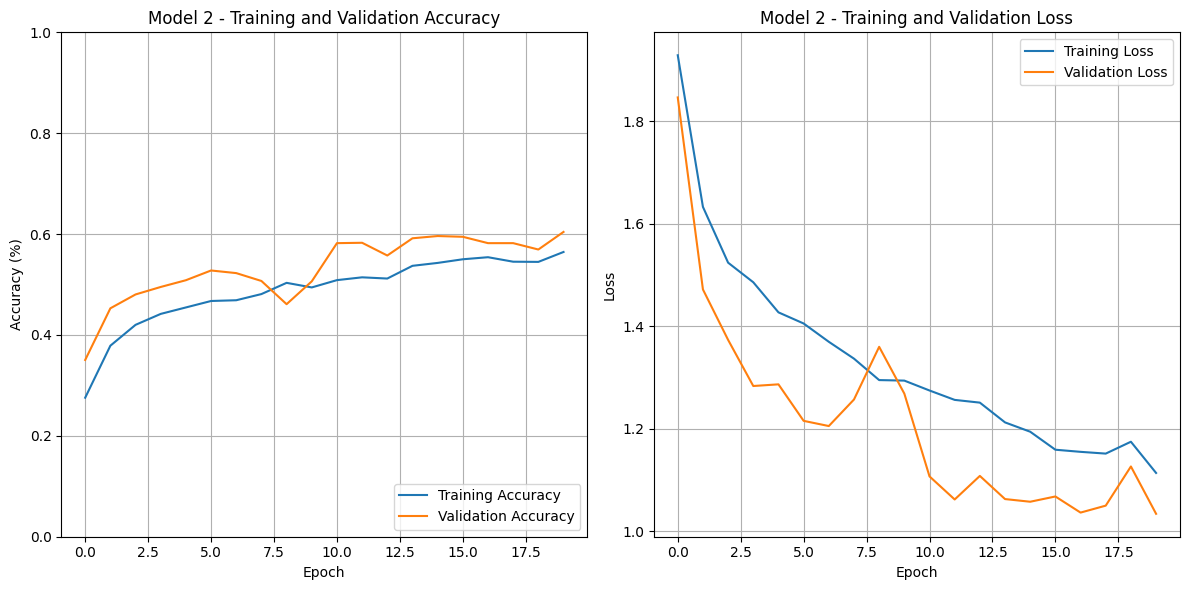

In [116]:
plot_model_performance(history2, epochs, 'Model 2');

In [103]:
acc1 = history1.history['accuracy'][-1]
val_acc1 = history1.history['val_accuracy'][-1]

acc2 = history2.history['accuracy'][-1]
val_acc2 = history2.history['val_accuracy'][-1]

print("Model1: accurracy: ", acc1,", Validation accuracy: ", val_acc1)
print("Model2: accurracy: ", acc2,", Validation accuracy: ",val_acc2)

Model1: accurracy:  0.8526785969734192 , Validation accuracy:  0.4966442883014679
Model2: accurracy:  0.5645400881767273 , Validation accuracy:  0.6043058633804321


So augmenting the dataset with some yield believable-looking images the each class did help with overfitting.

But it decreased the training accuracy by a lot.




Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [104]:
## Let's visualize the class imbalance

def class_distribution_count(directory):
  #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df




,Class,No. of Image
0,melanoma,438
1,nevus,357
2,pigmented benign keratosis,462
3,squamous cell carcinoma,181
4,dermatofibroma,95
5,actinic keratosis,114
6,basal cell carcinoma,376
7,seborrheic keratosis,77
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

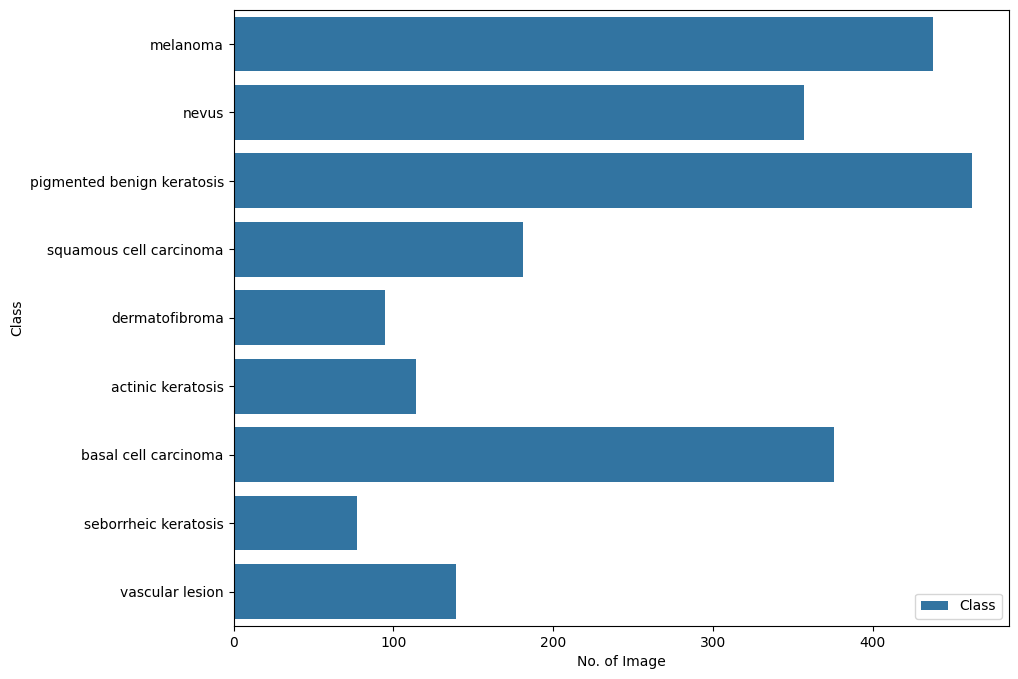

In [105]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")



As we can observe *seborrheic keratosis* has least number of samples while *pigmented benign keratosis* has highest number of samples and the difference between them is huge.


### Rectify the class imbalance

We will use Augmentor library to even the number of samples in the dataset.


The purpose of Augmentor is to automate image augmentation (artificial data generation) in order to expand datasets as input for machine learning algorithms, especially neural networks and deep learning.



In [106]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [107]:
import Augmentor
for class_name in class_names:
    p = Augmentor.Pipeline( str(data_dir_train)+'/'+ class_name)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x789CF214EF80>: 100%|██████████| 500/500 [00:05<00:00, 93.54 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789C9A24E6B0>: 100%|██████████| 500/500 [00:05<00:00, 97.34 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789C9BDA2050>: 100%|██████████| 500/500 [00:04<00:00, 101.44 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x789C98837D00>: 100%|██████████| 500/500 [00:13<00:00, 37.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x789C98894EB0>: 100%|██████████| 500/500 [00:11<00:00, 41.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789D5053ACB0>: 100%|██████████| 500/500 [00:04<00:00, 106.69 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x789C9881D420>: 100%|██████████| 500/500 [00:07<00:00, 68.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x789CB5197520>: 100%|██████████| 500/500 [00:04<00:00, 103.21 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789DAA3105E0>: 100%|██████████| 500/500 [00:04<00:00, 104.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [108]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [109]:
from glob import glob

# Count images in training directory
print("Training Dataset Image Counts:")
for class_name in sorted(os.listdir(data_dir_train)):
    class_path = os.path.join(data_dir_train, class_name)
    if os.path.isdir(class_path):
        image_paths = glob(os.path.join(class_path, '**', '*.[jp][pn]g'), recursive=True)
        print(f"  {class_name}: {len(image_paths)}")

# Count images in test directory
print("\nTest Dataset Image Counts:")
for class_name in sorted(os.listdir(data_dir_test)):
    class_path = os.path.join(data_dir_test, class_name)
    if os.path.isdir(class_path):
        image_paths = glob(os.path.join(class_path, '**', '*.[jp][pn]g'), recursive=True)
        print(f"  {class_name}: {len(image_paths)}")

Training Dataset Image Counts:
  actinic keratosis: 1114
  basal cell carcinoma: 1376
  dermatofibroma: 1095
  melanoma: 1438
  nevus: 1357
  pigmented benign keratosis: 1462
  seborrheic keratosis: 1077
  squamous cell carcinoma: 1181
  vascular lesion: 1139

Test Dataset Image Counts:
  actinic keratosis: 16
  basal cell carcinoma: 16
  dermatofibroma: 16
  melanoma: 16
  nevus: 16
  pigmented benign keratosis: 16
  seborrheic keratosis: 3
  squamous cell carcinoma: 16
  vascular lesion: 3


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Model 3

In [110]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [111]:
# Training dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [112]:
## Validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [125]:
### Your code goes here
model3 = Sequential()

# add augmented data
model3.add(data_augmentation)

# Rescaling
model3.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# 1st layer
model3.add(Conv2D(32, (3, 3), 1, activation='relu', input_shape=(img_height, img_width, 3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

# third conv layer
model3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model3.add(Flatten())
model3.add(Dense(128, activation='relu')) # fully connected
model3.add(BatchNormalization())

# softmax layer
model3.add(Dense(len(class_names), activation='softmax'))

Compile your model

In [126]:

model3.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model3.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_11 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,649 (25.36 MB)

 Trainable params: 6,648,393 (25.36 MB)

 Non-trainable params: 256 (1.00 KB)

#### **Todo:**  Train your model

In [127]:
epochs = 30
history3 = model3.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback])

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.3522 - loss: 1.7114 - val_accuracy: 0.3360 - val_loss: 2.1377
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.4587 - loss: 1.4365 - val_accuracy: 0.4637 - val_loss: 1.4063
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.4833 - loss: 1.3565 - val_accuracy: 0.5211 - val_loss: 1.2747
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.5019 - loss: 1.2967 - val_accuracy: 0.4869 - val_loss: 1.4901
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.5189 - loss: 1.2658 - val_accuracy: 0.4072 - val_loss: 1.7174
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.5409 - loss: 1.1940 - val_accuracy: 0.5274 - val_loss: 1.2570
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.5737 - loss: 1.1562 - val_accuracy: 0.5812 - val_loss: 1.0887
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.6007 - loss: 1.0933 - 

#### **Todo:**  Visualize the model results

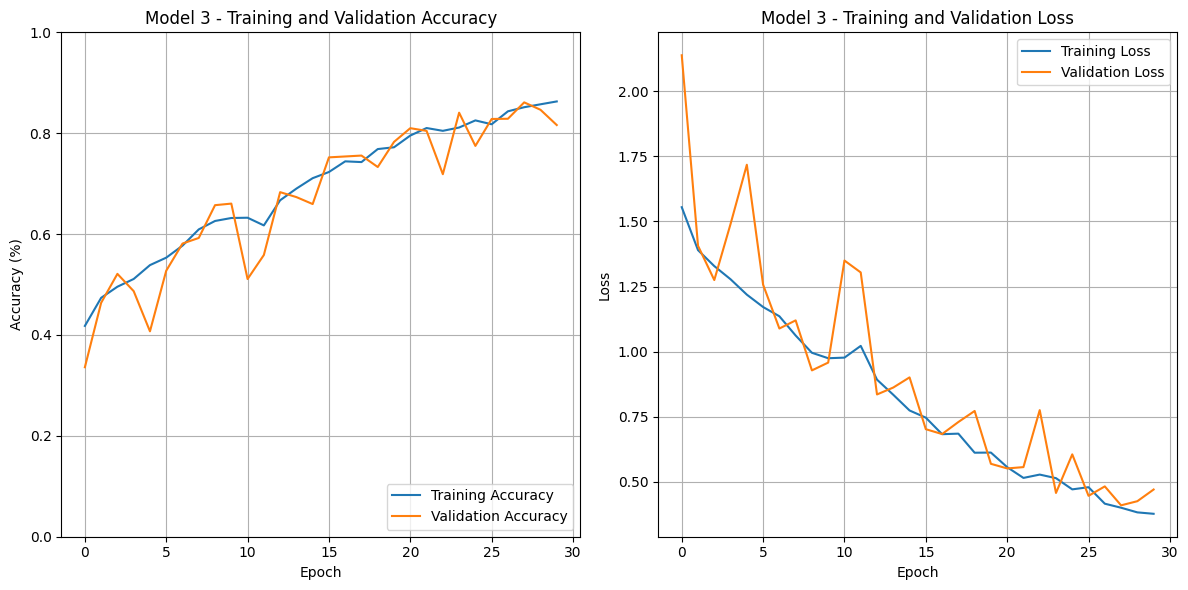

In [128]:
plot_model_performance(history3, epochs, 'Model 3');

In [129]:
acc1 = history1.history['accuracy'][-1]
val_acc1 = history1.history['val_accuracy'][-1]

acc2 = history2.history['accuracy'][-1]
val_acc2 = history2.history['val_accuracy'][-1]

acc3 = history3.history['accuracy'][-1]
val_acc3 = history3.history['val_accuracy'][-1]

print("Model1: accurracy: ", acc1,", Validation accuracy: ", val_acc1)
print("Model2: accurracy: ", acc2,", Validation accuracy: ",val_acc2)
print("Model3: accurracy: ", acc3,", Validation accuracy: ",val_acc3)

Model1: accurracy:  0.8526785969734192 , Validation accuracy:  0.4966442883014679
Model2: accurracy:  0.5645400881767273 , Validation accuracy:  0.6043058633804321
Model3: accurracy:  0.8629893064498901 , Validation accuracy:  0.8161993622779846


## Test accuracy on the test set

In [132]:
# Evaluate the test set on model 3

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

test_loss, test_accuracy = model3.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - accuracy: 0.4114 - loss: 3.5638
Test Accuracy: 43.22%


This low test accuracy could be a result of insufficient valid test data as majority of the training data is augmented